## Assess target specificity prediction

If we just assess how well we predict target activity across the board, the "all" concentration performs the best. However, we know that we shouldn't be able to predict target signals from CellPainting data that shows no bioactivity. We think that filtering for bioactivity (and also exlcuding non-specific cytotoxicity) should improve our ability to detect the specific signals in the data. 

To assess this, we look at how well we predict the overall signal instead of each biinary target classifier in isolation. 

We also hypothesize that prediction should improve if we exclude targets that are not expressed in primary human hepatocytes (PHH). 

In [38]:
import polars as pl
from scipy.stats import spearmanr
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import MultiComparison
import scipy.stats as stats

In [69]:
preds = pl.read_parquet("../1_snakemake/outputs/cellprofiler/mad_featselect/classifier_results/motive_binary_predictions.parquet")

In [70]:
preds_nodir = preds.filter(
    pl.col("Metadata_Label").str.contains("unknown_direction")
)

num_targets = (
    preds_nodir
    .filter(pl.col("y_actual") == 1)
    .group_by(["Metadata_OASIS_ID", "Metadata_AggType"])
    .agg(pl.count("y_actual").alias("Actual_target_count"))
)

num_pred_targets = (
    preds_nodir
    .filter(pl.col("y_pred") == 1)
    .group_by(["Metadata_OASIS_ID", "Metadata_AggType"])
    .agg(pl.count("y_actual").alias("Pred_target_count"))
)

preds_nodir = preds_nodir.join(num_targets, on=["Metadata_OASIS_ID", "Metadata_AggType"])
preds_nodir = preds_nodir.join(num_pred_targets, on=["Metadata_OASIS_ID", "Metadata_AggType"])

preds_nodir = preds_nodir.with_columns(
    (pl.col("y_actual")/pl.col("Actual_target_count")).alias("Actual_signal_strength"),
    (pl.col("y_pred")/pl.col("Pred_target_count")).alias("Pred_signal_strength"),
)

In [71]:
result = []
for agg_type, group in preds_nodir.group_by("Metadata_AggType"):
    sp_corr, sp_p = spearmanr(group["Actual_signal_strength"].to_list(), group["Pred_signal_strength"].to_list())

    result.append({"Metadata_AggType": agg_type, 
                   "spearman_corr": sp_corr, "spearman_pval": sp_p
                   })

result_df = pl.DataFrame(result)
print(result_df)

shape: (5, 3)
┌──────────────────┬───────────────┬───────────────┐
│ Metadata_AggType ┆ spearman_corr ┆ spearman_pval │
│ ---              ┆ ---           ┆ ---           │
│ list[str]        ┆ f64           ┆ f64           │
╞══════════════════╪═══════════════╪═══════════════╡
│ ["all"]          ┆ 0.022432      ┆ 8.1770e-167   │
│ ["firstpod"]     ┆ 0.018265      ┆ 4.7406e-20    │
│ ["lastpodcc"]    ┆ 0.050333      ┆ 2.3947e-124   │
│ ["allpod"]       ┆ 0.048495      ┆ 5.5170e-138   │
│ ["allpodcc"]     ┆ 0.042048      ┆ 2.4602e-87    │
└──────────────────┴───────────────┴───────────────┘


Note: for both Dino and CPCNN, "all" is the worst. For Dino, allpodcc was best while for CPCNN, allpod was the best. 

(2840895, 12)
(67867, 12)


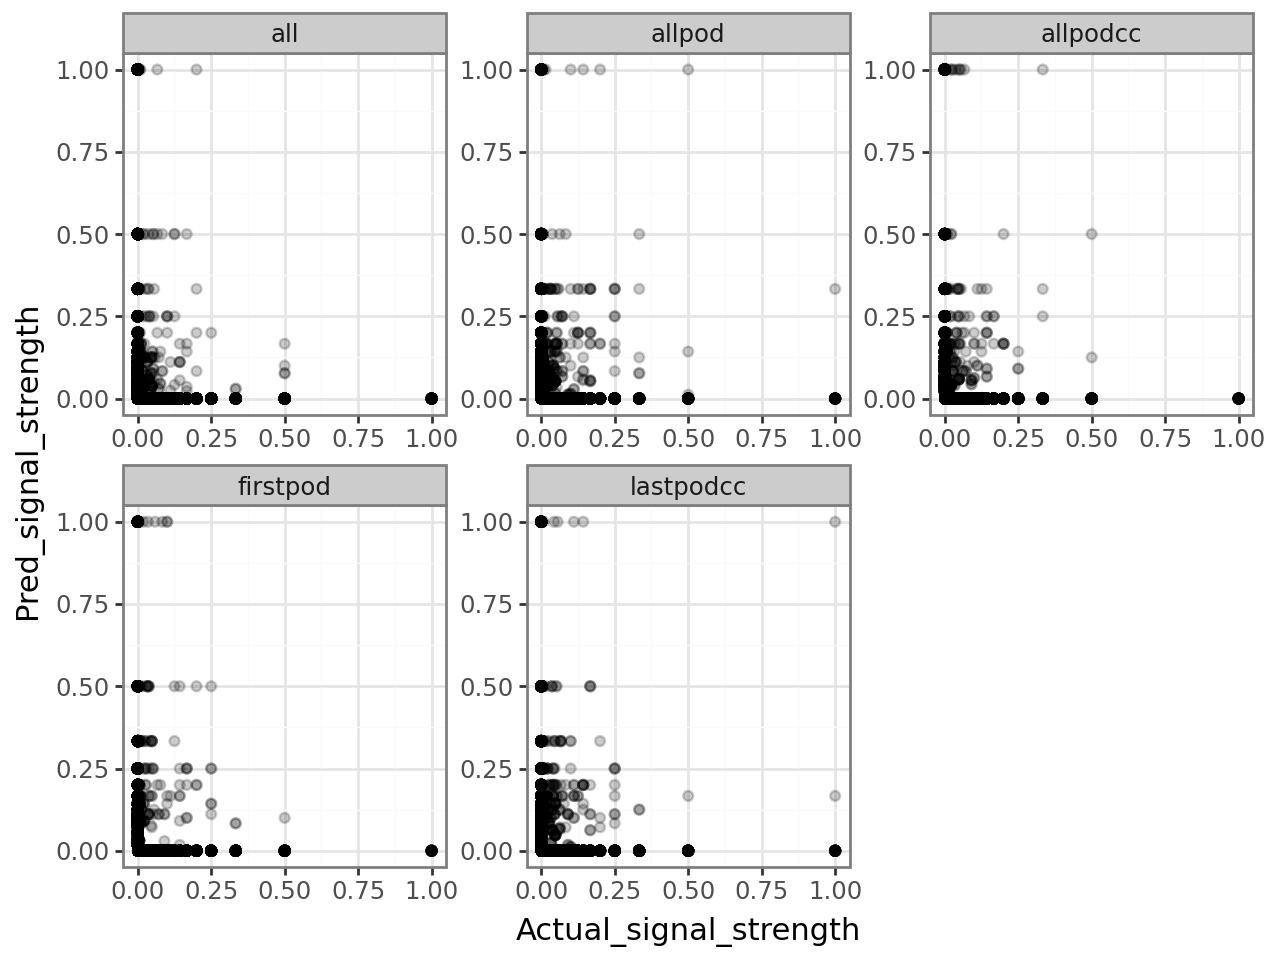

In [6]:
from plotnine import ggplot, aes, theme_bw, labs, geom_histogram, facet_wrap, geom_point

print(preds_nodir.shape)
preds_nodir_plot = preds_nodir.filter(
    ~((pl.col("Actual_signal_strength") == 0) & (pl.col("Pred_signal_strength") == 0))
)
print(preds_nodir_plot.shape)

plot = (
    ggplot(preds_nodir_plot, aes(x='Actual_signal_strength', y="Pred_signal_strength")) +
    geom_point(alpha=0.2) +
    facet_wrap("Metadata_AggType", scales="free") +
    theme_bw()
)
plot.show()

## Consider expression in PHH

In [72]:
phh_exp = pl.read_parquet("./compiled_results/motive_highexp_PHH.parquet").select("GeneSymbol").to_series().unique().to_list()

In [73]:
def get_prefix(label: str):
    return label.split("_")[0]

print(preds.shape)

preds_phh = preds.with_columns(
    pl.col("Metadata_Label").map_elements(lambda x: get_prefix(x), return_dtype=pl.String).alias("GeneSymbol"),
).filter(
    pl.col("GeneSymbol").is_in(phh_exp)
)

print(preds_phh.shape)

(12971289, 8)
(8909024, 9)


In [74]:
preds_nodir = preds_phh.filter(
    pl.col("Metadata_Label").str.contains("unknown_direction")
)

num_targets = (
    preds_nodir
    .filter(pl.col("y_actual") == 1)
    .group_by(["Metadata_OASIS_ID", "Metadata_AggType"])
    .agg(pl.count("y_actual").alias("Actual_target_count"))
)

num_pred_targets = (
    preds_nodir
    .filter(pl.col("y_pred") == 1)
    .group_by(["Metadata_OASIS_ID", "Metadata_AggType"])
    .agg(pl.count("y_actual").alias("Pred_target_count"))
)

preds_nodir = preds_nodir.join(num_targets, on=["Metadata_OASIS_ID", "Metadata_AggType"])
preds_nodir = preds_nodir.join(num_pred_targets, on=["Metadata_OASIS_ID", "Metadata_AggType"])

preds_nodir = preds_nodir.with_columns(
    (pl.col("y_actual")/pl.col("Actual_target_count")).alias("Actual_signal_strength"),
    (pl.col("y_pred")/pl.col("Pred_target_count")).alias("Pred_signal_strength"),
)

In [75]:
result = []
for agg_type, group in preds_nodir.group_by("Metadata_AggType"):
    sp_corr, sp_p = spearmanr(group["Actual_signal_strength"].to_list(), group["Pred_signal_strength"].to_list())

    result.append({"Metadata_AggType": agg_type, 
                   "spearman_corr": sp_corr, "spearman_pval": sp_p
                   })

result_df = pl.DataFrame(result)
print(result_df)

shape: (5, 3)
┌──────────────────┬───────────────┬───────────────┐
│ Metadata_AggType ┆ spearman_corr ┆ spearman_pval │
│ ---              ┆ ---           ┆ ---           │
│ list[str]        ┆ f64           ┆ f64           │
╞══════════════════╪═══════════════╪═══════════════╡
│ ["all"]          ┆ 0.028106      ┆ 5.4963e-127   │
│ ["allpodcc"]     ┆ 0.072351      ┆ 8.7092e-103   │
│ ["lastpodcc"]    ┆ 0.083614      ┆ 2.4805e-138   │
│ ["firstpod"]     ┆ 0.036603      ┆ 4.1015e-32    │
│ ["allpod"]       ┆ 0.079886      ┆ 7.5388e-158   │
└──────────────────┴───────────────┴───────────────┘


(1289426, 13)
(29602, 13)


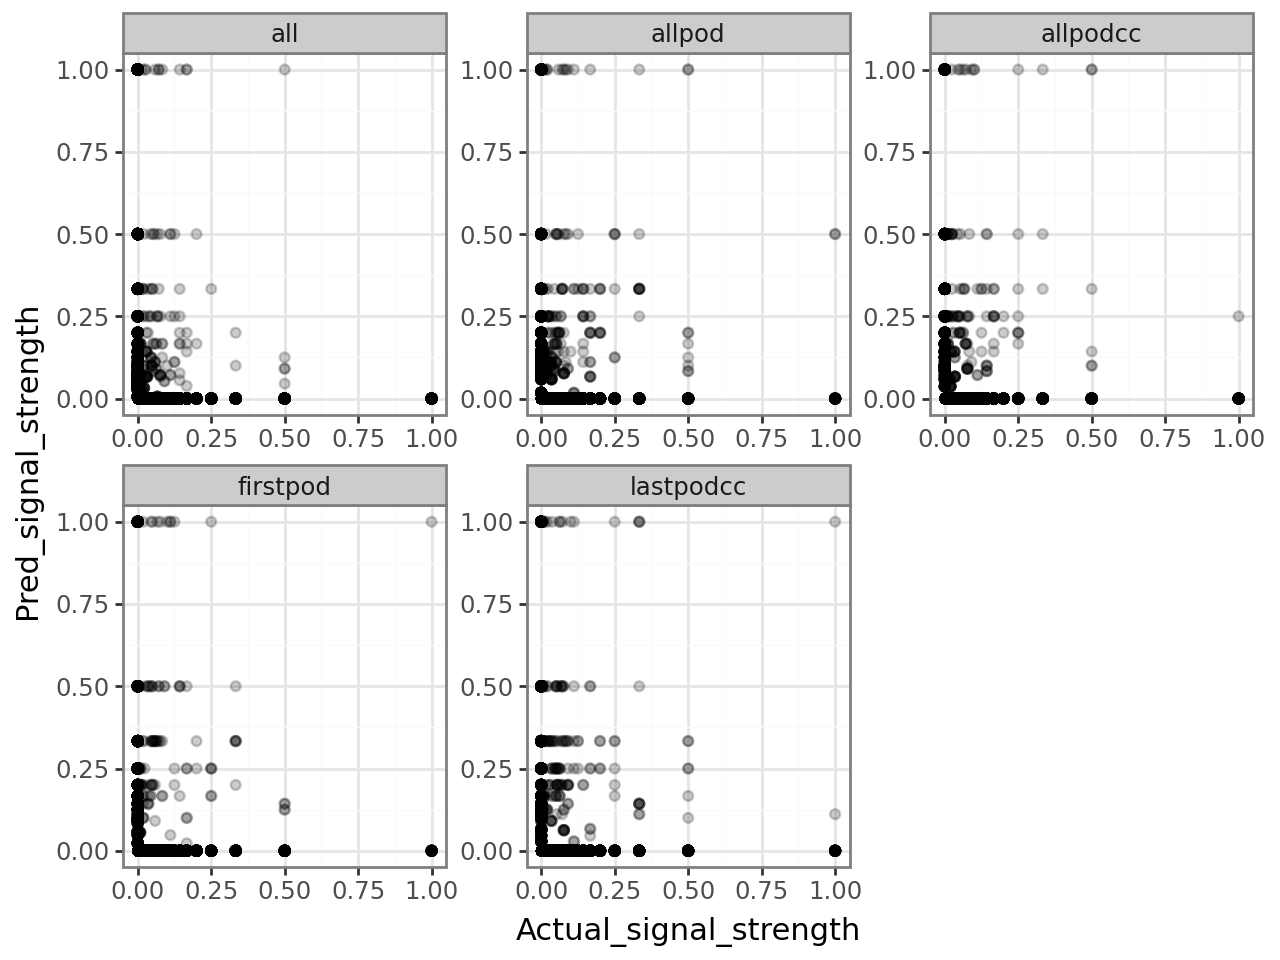

In [11]:
from plotnine import ggplot, aes, theme_bw, labs, geom_histogram, facet_wrap, geom_point

print(preds_nodir.shape)
preds_nodir_plot = preds_nodir.filter(
    ~((pl.col("Actual_signal_strength") == 0) & (pl.col("Pred_signal_strength") == 0))
)
print(preds_nodir_plot.shape)

plot = (
    ggplot(preds_nodir_plot, aes(x='Actual_signal_strength', y="Pred_signal_strength")) +
    geom_point(alpha=0.2) +
    facet_wrap("Metadata_AggType", scales="free") +
    theme_bw()
)
plot.show()

## Compare performance metrics

In [77]:
motive_preds = pl.read_parquet("./compiled_results/compiled_motive_metrics.parquet")

def get_prefix(label: str):
    return label.split("_")[0]

motive_preds = motive_preds.with_columns(
    pl.col("Metadata_Label").map_elements(lambda x: get_prefix(x), return_dtype=pl.String).alias("GeneSymbol"),
).with_columns(
    pl.when(pl.col("GeneSymbol").is_in(phh_exp)).then(pl.lit("Yes")).otherwise(pl.lit("No")).alias("PHH_exp")
)

df_pandas = motive_preds.to_pandas()

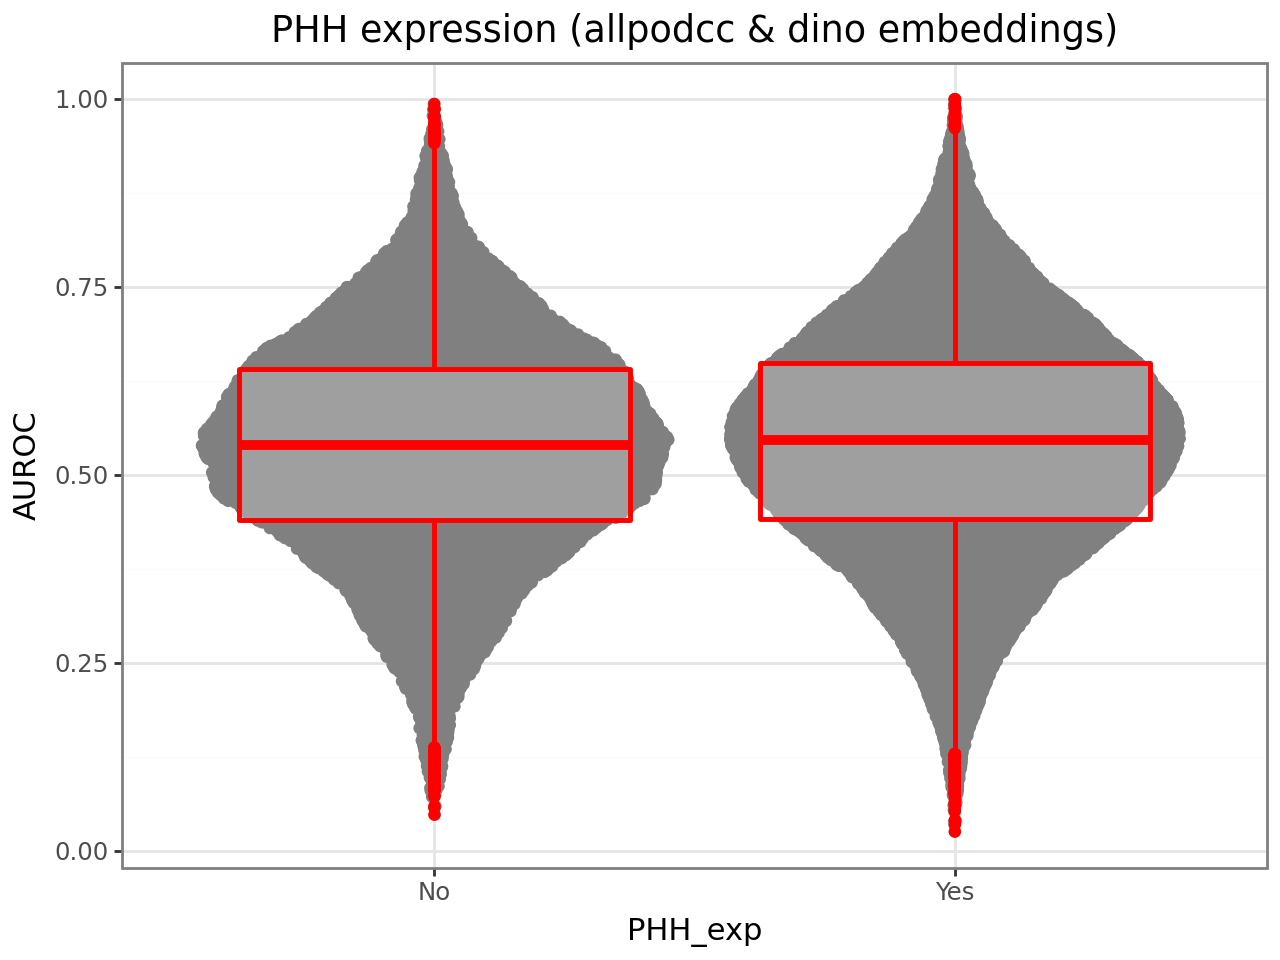

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
    No    Yes   0.0063   0.0 0.0062 0.0065   True
-------------------------------------------------
[0.]


In [80]:
from plotnine import ggplot, aes, geom_sina, geom_boxplot, labs, theme_bw
metric = "AUROC"

plot = (
    ggplot(motive_preds, aes(x='PHH_exp', y=metric)) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='PHH expression (allpodcc & dino embeddings)') 
    + theme_bw()
)
plot.show()

model = smf.mixedlm(f"{metric} ~ PHH_exp", df_pandas, groups=df_pandas["Feat_type"],
                    re_formula="~Metadata_AggType")
result = model.fit()
df_pandas["fitted_values"] = result.fittedvalues

mc = MultiComparison(df_pandas["fitted_values"], df_pandas["PHH_exp"])
tukey_result = mc.tukeyhsd()

tukey_pvals = tukey_result.pvalues
print(tukey_result.summary())
print(tukey_pvals)


In [ ]:
# Simple t-test
PHH_yes = motive_pandas[motive_pandas["PHH_exp"] == "Yes"][metric]
PHH_no = motive_pandas[motive_pandas["PHH_exp"] == "No"][metric]

t_stat, p_value = stats.ttest_ind(PHH_yes, PHH_no)

mean_diff = PHH_yes.mean() - PHH_no.mean()

print(f"Mean difference: {mean_diff}")
print(f"T-test statistic: {t_stat}")
print(f"P-value: {p_value}")
